In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset

# Generate synthetic data
def generate_data(num_samples=1000, seq_length=50):
    t = np.linspace(0, 4 * np.pi, seq_length)
    X1 = np.sin(t) + 0.1 * np.random.randn(num_samples, seq_length)
    X2 = np.cos(t) + 0.1 * np.random.randn(num_samples, seq_length)
    trend = np.linspace(0, 1, seq_length)
    Y = 0.5 * X1 + 0.3 * X2 + trend + 0.1 * np.random.randn(num_samples, seq_length)
    return X1, X2, Y

# Define the noise prediction network
class DiffusionModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, seq_length):
        super(DiffusionModel, self).__init__()
        self.seq_length = seq_length
        self.encoder = nn.Linear(input_dim, hidden_dim)  # Correct input_dim
        self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.decoder = nn.Linear(hidden_dim, 1)

    def forward(self, X, Y_noisy, timestep):
        # Concatenate input time series and noisy target
        input_data = torch.cat([X, Y_noisy, timestep], dim=-1)  # Now input_dim=4
        encoded = torch.relu(self.encoder(input_data))
        rnn_out, _ = self.rnn(encoded)
        return self.decoder(rnn_out)

# Diffusion process
def add_noise(Y, beta_schedule, timestep):
    beta = beta_schedule[timestep]
    noise = torch.randn_like(Y)
    Y_noisy = torch.sqrt(1 - beta) * Y + torch.sqrt(beta) * noise
    return Y_noisy, noise

# Beta schedule (linear)
def beta_schedule(steps):
    return torch.linspace(1e-4, 0.02, steps)

# Training setup
def train_model(model, data_loader, optimizer, beta_schedule, num_steps, device):
    model.train()
    model.to(device)
    criterion = nn.MSELoss()
    for epoch in range(50):
        for X, Y in data_loader:
            X, Y = X.to(device), Y.to(device)
            optimizer.zero_grad()
            loss = 0
            for t in range(num_steps - 1, 0, -1):
                Y_noisy, noise = add_noise(Y, beta_schedule, t)
                Y_noisy = Y_noisy.unsqueeze(-1)  # Ensure Y_noisy is 3D
                timestep = torch.full((X.size(0), X.size(1), 1), t / num_steps, device=device)
                noise_pred = model(X, Y_noisy, timestep)
                loss += criterion(noise_pred, noise.unsqueeze(-1))  # Match noise dimension
            loss.backward()
            optimizer.step()
        print(f"Epoch {epoch + 1}, Loss: {loss.item():.4f}")

# Generate data
X1, X2, Y = generate_data()
X = np.stack([X1, X2], axis=-1)  # Shape: (num_samples, seq_length, 2)

# Convert to PyTorch tensors
X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Initialize model, optimizer, and beta schedule
seq_length = X.shape[1]
input_dim = 4  # Two input series + timestep
hidden_dim = 64
model = DiffusionModel(input_dim, hidden_dim, seq_length)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
beta_schedule_vals = beta_schedule(100)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train the model
train_model(model, data_loader, optimizer, beta_schedule_vals, num_steps=100, device=device)


Epoch 1, Loss: 90.7167
Epoch 2, Loss: 67.4859
Epoch 3, Loss: 58.7531
Epoch 4, Loss: 54.9527
Epoch 5, Loss: 54.7270
Epoch 6, Loss: 52.5028
Epoch 7, Loss: 54.8426
Epoch 8, Loss: 57.0550
Epoch 9, Loss: 54.3009
Epoch 10, Loss: 53.0822
Epoch 11, Loss: 53.3176
Epoch 12, Loss: 53.1109
Epoch 13, Loss: 56.3774
Epoch 14, Loss: 52.6908
Epoch 15, Loss: 53.2637
Epoch 16, Loss: 56.3207
Epoch 17, Loss: 53.6367
Epoch 18, Loss: 53.1657
Epoch 19, Loss: 54.9643
Epoch 20, Loss: 53.2238
Epoch 21, Loss: 57.4947
Epoch 22, Loss: 54.4980
Epoch 23, Loss: 56.3419
Epoch 24, Loss: 54.2735
Epoch 25, Loss: 52.4205
Epoch 26, Loss: 52.6771
Epoch 27, Loss: 55.6201
Epoch 28, Loss: 54.6960
Epoch 29, Loss: 53.5470
Epoch 30, Loss: 55.8396
Epoch 31, Loss: 55.1471
Epoch 32, Loss: 53.7940
Epoch 33, Loss: 53.0821
Epoch 34, Loss: 53.4480
Epoch 35, Loss: 53.9437
Epoch 36, Loss: 53.9422
Epoch 37, Loss: 54.8378
Epoch 38, Loss: 54.1790
Epoch 39, Loss: 53.1420
Epoch 40, Loss: 56.7404
Epoch 41, Loss: 54.5555
Epoch 42, Loss: 55.3679
E

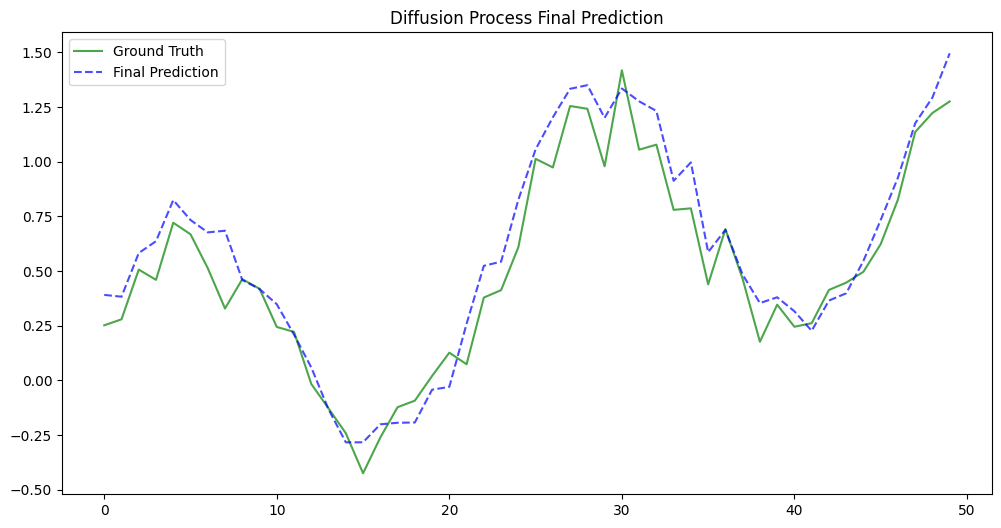

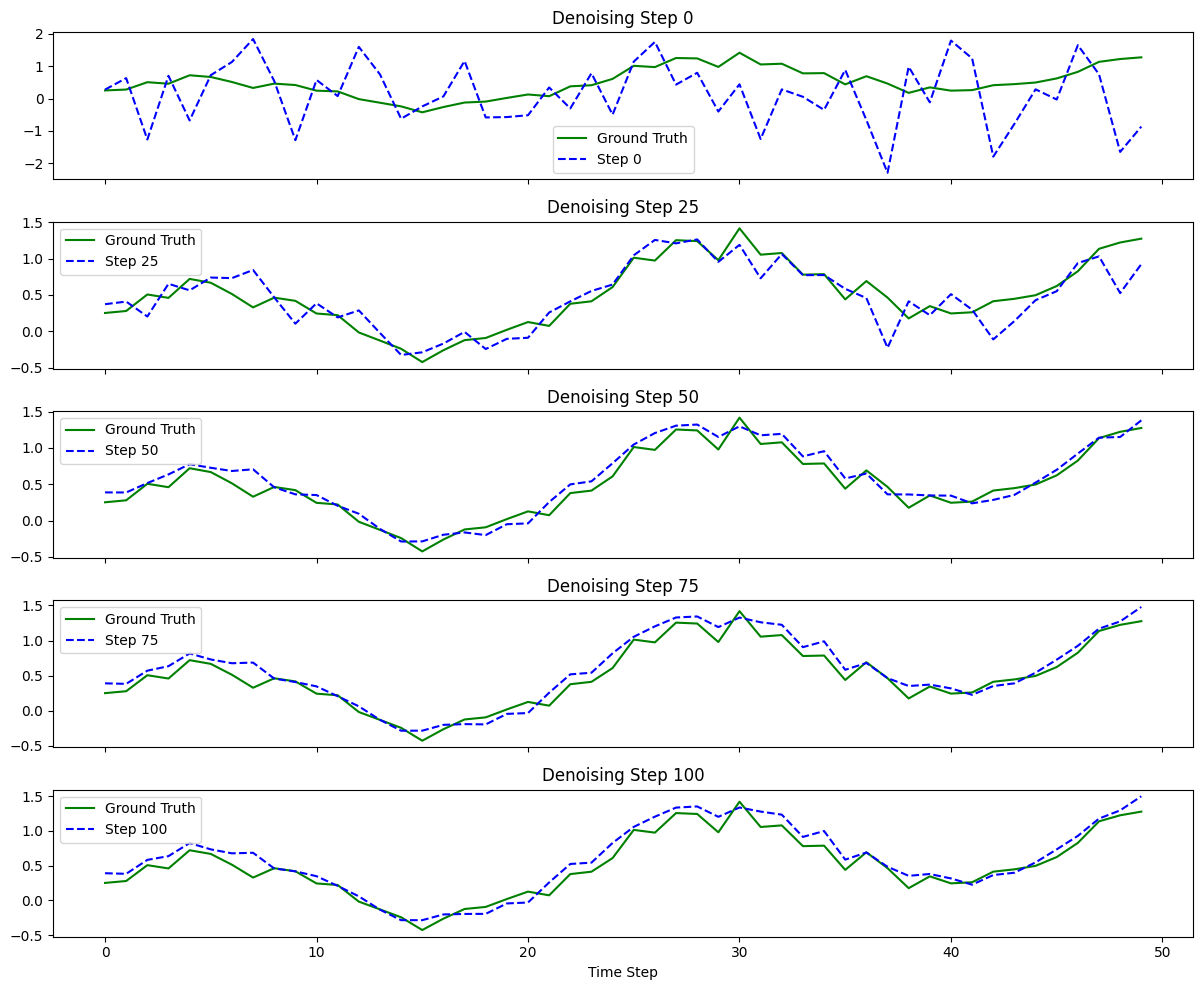

In [9]:
# Test the model
model.eval()
model.to(device)
with torch.no_grad():
    # Prepare a single example
    X_sample, Y_sample = next(iter(data_loader))
    X_sample, Y_sample = X_sample[:1].to(device), Y_sample[:1].to(device)
    Y_noisy = torch.randn_like(Y_sample).unsqueeze(-1)  # Start with noisy prediction
    Y_trajectory = [Y_noisy.squeeze(-1).cpu().numpy()]  # Track intermediate results

    # Simulate diffusion
    for t in range(99, -1, -1):  # Reverse diffusion steps
        timestep = torch.full((X_sample.size(0), X_sample.size(1), 1), t / 100, device=device)
        noise_pred = model(X_sample, Y_noisy, timestep)

        # Update the noisy prediction using the diffusion update rule
        beta_t = beta_schedule_vals[t]
        Y_noisy = (Y_noisy - beta_t * noise_pred) / torch.sqrt(1 - beta_t.to(device))  # Ensure tensor type
        Y_trajectory.append(Y_noisy.squeeze(-1).cpu().numpy())  # Store the result

    # Plot results
    plt.figure(figsize=(12, 6))
    plt.plot(Y_sample[0].cpu().numpy(), label="Ground Truth", alpha=0.7, color="green")
    plt.plot(Y_trajectory[-1][0], label="Final Prediction", alpha=0.7, color="blue", linestyle="--")
    plt.title("Diffusion Process Final Prediction")
    plt.legend()
    plt.show()

    # Visualize intermediate steps
    fig, axes = plt.subplots(5, 1, figsize=(12, 10), sharex=True)
    steps = np.linspace(0, 100, 5, dtype=int)  # Select steps for visualization
    for i, step in enumerate(steps):
        axes[i].plot(Y_sample[0].cpu().numpy(), label="Ground Truth", color="green")
        axes[i].plot(Y_trajectory[step][0], label=f"Step {step}", linestyle="--", color="blue")
        axes[i].legend()
        axes[i].set_title(f"Denoising Step {step}")
    plt.xlabel("Time Step")
    plt.tight_layout()
    plt.show()


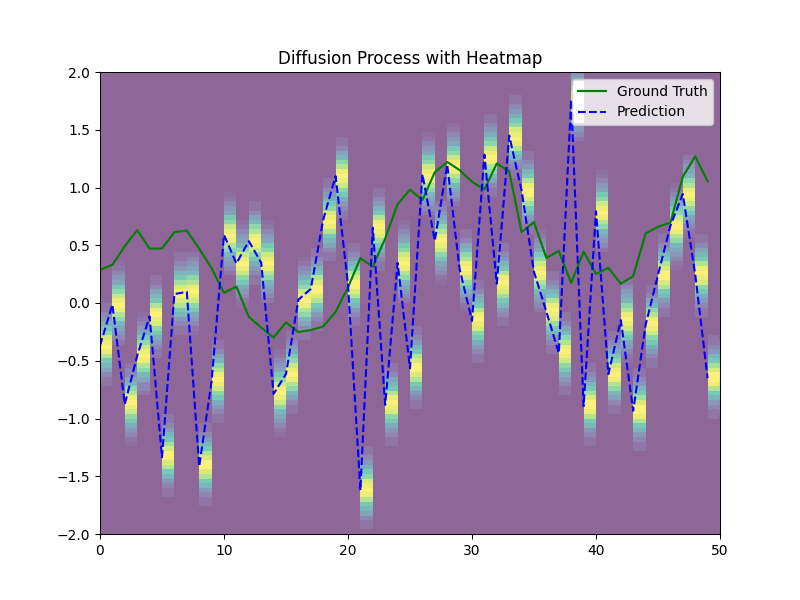

/usr/local/lib/python3.10/dist-packages/matplotlib/animation.py:892: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [18]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import numpy as np
import torch

def visualize_diffusion_with_heatmap(model, X_sample, Y_sample, num_steps, beta_schedule):
    model.eval()
    trajectory = []
    heatmaps = []

    with torch.no_grad():
        Y_noisy = torch.randn_like(Y_sample).unsqueeze(-1)
        trajectory.append(Y_noisy.squeeze(-1).cpu().numpy())

        for t in range(num_steps - 1, -1, -1):
            timestep = torch.full((X_sample.size(0), X_sample.size(1), 1), t / num_steps, device=X_sample.device)
            noise_pred = model(X_sample, Y_noisy, timestep)
            beta_t = beta_schedule[t]
            Y_noisy = (Y_noisy - beta_t * noise_pred) / torch.sqrt(1 - beta_t)
            trajectory.append(Y_noisy.squeeze(-1).cpu().numpy())

            # Generate the heatmap
            y_range = np.linspace(-2, 2, 100)
            current_heatmap = np.exp(
                -((y_range[:, None] - Y_noisy[0, :, 0].cpu().numpy()) ** 2) / (2 * beta_t)
            )
            heatmaps.append(current_heatmap)

    # Combine all heatmaps to get min/max values for a consistent colormap range
    all_heatmap_values = np.concatenate([hm.flatten() for hm in heatmaps])
    global_min, global_max = all_heatmap_values.min(), all_heatmap_values.max()

    fig, ax = plt.subplots(figsize=(8, 6))
    gt_line, = ax.plot(Y_sample[0].cpu().numpy(), label="Ground Truth", color="green")
    pred_line, = ax.plot([], [], label="Prediction", color="blue", linestyle="--")

    # Initialize with dummy data
    heatmap_plot = ax.imshow(
        np.zeros((100, len(Y_sample[0]))),
        extent=[0, len(Y_sample[0]), -2, 2],
        origin="lower",
        aspect="auto",
        cmap="viridis",
        alpha=0.6
    )

    ax.legend()
    ax.set_title("Diffusion Process with Heatmap")

    def init():
        pred_line.set_data([], [])
        # Fix the colormap to global min/max so that each update can reflect changes
        heatmap_plot.set_clim(global_min, global_max)
        return pred_line, heatmap_plot

    def update(frame):
        # Index offset: the first heatmap corresponds to trajectory[1], not trajectory[0]
        Y_pred = trajectory[frame + 1][0]
        current_heatmap = heatmaps[frame]
        pred_line.set_data(range(len(Y_pred)), Y_pred)
        heatmap_plot.set_data(current_heatmap)
        return pred_line, heatmap_plot

    ani = FuncAnimation(fig, update, frames=len(heatmaps), init_func=init, blit=False, repeat=False)
    ani.save("diffusion_heatmap.gif", writer=PillowWriter(fps=10))
    plt.close(fig)

    return ani


# Test and visualize the diffusion process
X_sample, Y_sample = next(iter(data_loader))
X_sample = X_sample[:1].to(device)  # Take a single example for visualization and move to device
Y_sample = Y_sample[:1].to(device)

# Generate and save the animation
animation = visualize_diffusion_with_heatmap(model, X_sample, Y_sample, num_steps=100, beta_schedule=beta_schedule_vals)

# Display the animation
from IPython.display import Image
Image(filename="diffusion_heatmap.gif")




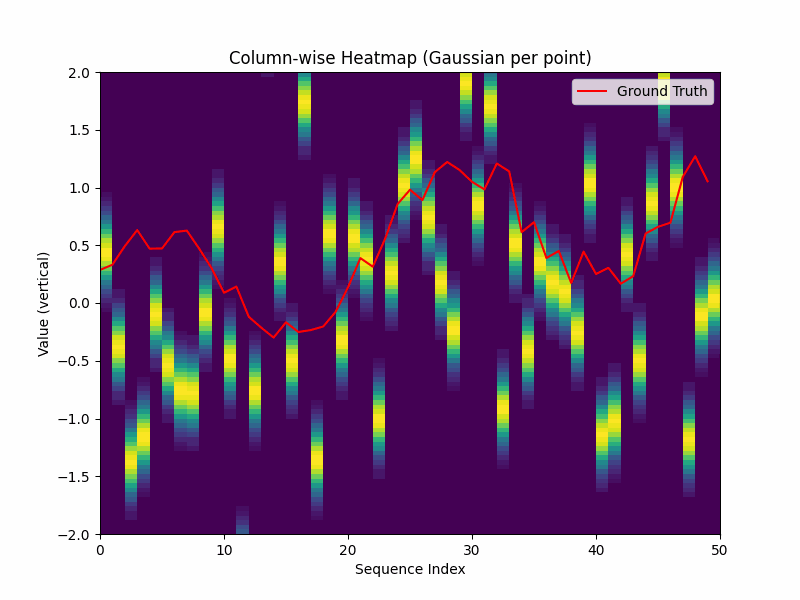

In [23]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter

def visualize_columnwise_heatmap(model, X_sample, Y_sample, num_steps, beta_schedule):
    model.eval()
    trajectory = []

    with torch.no_grad():
        # Initial noisy estimate
        Y_noisy = torch.randn_like(Y_sample).unsqueeze(-1)
        for t in range(num_steps):
            trajectory.append(Y_noisy.squeeze(-1).cpu().numpy())  # shape (1, seq_len)
            timestep = torch.full(
                (X_sample.size(0), X_sample.size(1), 1),
                t / num_steps,
                device=X_sample.device
            )
            noise_pred = model(X_sample, Y_noisy, timestep)
            beta_t = beta_schedule[t]
            Y_noisy = (Y_noisy - beta_t * noise_pred) / torch.sqrt(1 - beta_t)

    # trajectory is a list of length [num_steps],
    # each element has shape (1, seq_len). We'll convert it to np.array of shape (num_steps, seq_len).
    trajectory = np.concatenate(trajectory, axis=0)  # shape => (num_steps, seq_len)

    # Create a list of heatmaps, one per step.
    # Each heatmap is shape [100 (vertical), seq_len (horizontal)].
    y_vals = np.linspace(-2, 2, 100)
    sigma = 0.2  # Spread of each Gaussian in a column
    heatmaps = []

    for step_idx in range(num_steps):
        y_current = trajectory[step_idx]  # shape: (seq_len,)
        heatmap_2d = np.zeros((100, y_current.shape[0]))  # (vertical, seq_len)

        for i in range(y_current.shape[0]):
            center = y_current[i]  # the vertical center for column i
            # Gaussian for column i
            heatmap_2d[:, i] = np.exp(-0.5 * ((y_vals - center) / sigma)**2)

        heatmaps.append(heatmap_2d)

    # For consistent color scaling, find global min and max
    all_values = np.concatenate([hm.ravel() for hm in heatmaps])
    vmin, vmax = all_values.min(), all_values.max()

    # Set up figure and axes
    fig, ax = plt.subplots(figsize=(8, 6))

    # Initialize heatmap with the first frame
    im = ax.imshow(
        heatmaps[0],
        origin="lower",
        aspect="auto",
        extent=[0, Y_sample.shape[1], -2, 2],
        cmap="viridis",
        vmin=vmin,
        vmax=vmax
    )
    ax.set_title("Column-wise Heatmap (Gaussian per point)")
    ax.set_xlabel("Sequence Index")
    ax.set_ylabel("Value (vertical)")

    # Optional: also plot the ground truth at the top
    gt_line, = ax.plot(
        np.arange(Y_sample.shape[1]),
        Y_sample[0].cpu().numpy(),
        color="red",
        label="Ground Truth"
    )
    ax.legend()

    def update(frame):
        im.set_data(heatmaps[frame])
        return [im]

    ani = FuncAnimation(fig, update, frames=num_steps, interval=200, blit=False)
    ani.save("columnwise_heatmap.gif", writer=PillowWriter(fps=5))
    plt.close(fig)

    return ani




animation = visualize_columnwise_heatmap(model, X_sample, Y_sample, num_steps=100, beta_schedule=beta_schedule_vals)
Image(filename="columnwise_heatmap.gif")

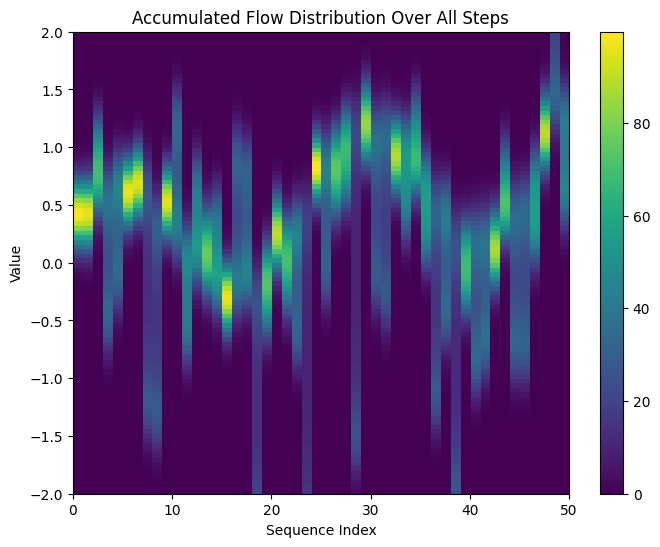

In [25]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_accumulated_flow(model, X_sample, Y_sample, num_steps, beta_schedule):
    model.eval()
    trajectory = []

    with torch.no_grad():
        Y_noisy = torch.randn_like(Y_sample).unsqueeze(-1)
        for t in range(num_steps):
            trajectory.append(Y_noisy.squeeze(-1).cpu().numpy())
            timestep = torch.full(
                (X_sample.size(0), X_sample.size(1), 1),
                t / num_steps,
                device=X_sample.device
            )
            noise_pred = model(X_sample, Y_noisy, timestep)
            beta_t = beta_schedule[t]
            Y_noisy = (Y_noisy - beta_t * noise_pred) / torch.sqrt(1 - beta_t)

    trajectory = np.concatenate(trajectory, axis=0)  # shape => (num_steps, seq_len)

    y_vals = np.linspace(-2, 2, 100)
    sigma = 0.2
    heatmaps = []
    for step_idx in range(num_steps):
        y_current = trajectory[step_idx]  # shape (seq_len,)
        heatmap_2d = np.zeros((100, y_current.shape[0]))
        for i in range(y_current.shape[0]):
            center = y_current[i]
            heatmap_2d[:, i] = np.exp(-0.5 * ((y_vals - center) / sigma)**2)
        heatmaps.append(heatmap_2d)

    accumulated = np.sum(heatmaps, axis=0)

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(
        accumulated,
        origin="lower",
        aspect="auto",
        extent=[0, Y_sample.shape[1], -2, 2],
        cmap="viridis"
    )
    plt.colorbar(im, ax=ax)
    ax.set_title("Accumulated Flow Distribution Over All Steps")
    ax.set_xlabel("Sequence Index")
    ax.set_ylabel("Value")
    plt.show()

visualize_accumulated_flow(model, X_sample, Y_sample, num_steps=100, beta_schedule=beta_schedule_vals)

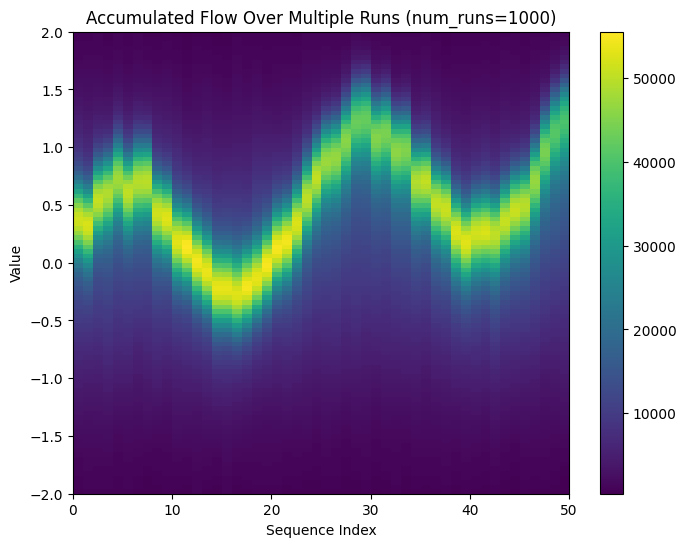

In [27]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def visualize_accumulated_flow_multiple_runs(
    model,
    X_sample,
    Y_sample,
    num_steps,
    beta_schedule,
    num_runs=5
):
    model.eval()
    seq_len = Y_sample.shape[1]
    y_vals = np.linspace(-2, 2, 100)
    sigma = 0.2
    accumulated = np.zeros((100, seq_len))

    for run_idx in range(num_runs):
        Y_noisy = torch.randn_like(Y_sample).unsqueeze(-1)
        trajectory = []
        with torch.no_grad():
            for t in range(num_steps):
                trajectory.append(Y_noisy.squeeze(-1).cpu().numpy())
                timestep = torch.full(
                    (X_sample.size(0), X_sample.size(1), 1),
                    t / num_steps,
                    device=X_sample.device
                )
                noise_pred = model(X_sample, Y_noisy, timestep)
                beta_t = beta_schedule[t]
                Y_noisy = (Y_noisy - beta_t * noise_pred) / torch.sqrt(1 - beta_t)
        trajectory = np.concatenate(trajectory, axis=0)  # (num_steps, seq_len)

        heatmaps = []
        for step_idx in range(num_steps):
            y_current = trajectory[step_idx]
            heatmap_2d = np.zeros((100, seq_len))
            for i in range(seq_len):
                center = y_current[i]
                heatmap_2d[:, i] = np.exp(-0.5 * ((y_vals - center) / sigma) ** 2)
            heatmaps.append(heatmap_2d)

        # Sum all steps from this run
        run_sum = np.sum(heatmaps, axis=0)
        accumulated += run_sum

    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(
        accumulated,
        origin="lower",
        aspect="auto",
        extent=[0, seq_len, -2, 2],
        cmap="viridis"
    )
    plt.colorbar(im, ax=ax)
    ax.set_title("Accumulated Flow Over Multiple Runs (num_runs={})".format(num_runs))
    ax.set_xlabel("Sequence Index")
    ax.set_ylabel("Value")
    plt.show()

visualize_accumulated_flow_multiple_runs(model, X_sample, Y_sample, num_steps=100, beta_schedule=beta_schedule_vals, num_runs=1000)